# Task: Text Clustering with Custom KMeans

Using sentence_transformers, convert a set of texts into embeddings, and apply clustering using a custom implementation of KMeans. The goal is to group similar texts based on different distance metrics (such as cosine similarity, Euclidean distance, or Manhattan distance) implemented in the KMeans algorithm.

## 1. Data loading

Load the GO Emotions dataset from Hugging Face to obtain the texts that will be clustered. If you prefer some other dataset you can use it.

In [42]:
from time import time

from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [1]:
dataset = load_dataset("google-research-datasets/go_emotions", split="train")

Print some examples

In [2]:
for i in range(5):
    print(f"Text {i+1}: {dataset[i]['text']}")

Text 1: My favourite food is anything I didn't have to cook myself.
Text 2: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
Text 3: WHY THE FUCK IS BAYLESS ISOING
Text 4: To make her feel threatened
Text 5: Dirty Southern Wankers


## 2. Convert texts to embeddings

Use the sentence-transformers library to transform the texts into embeddings (numerical vectors) for clustering.

In [4]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [5]:
texts = dataset["text"]
embeddings = model.encode(texts, show_progress_bar=True)


print(f"Shape of embeddings: {embeddings.shape}")

Batches:   0%|          | 0/1357 [00:00<?, ?it/s]

Shape of embeddings: (43410, 384)


## 3. Implement custom KMeans

Create a custom implementation of KMeans, supporting at leas four different distance metrics (Correlation, Euclidean, Cosine, Mahalanobis). You shouldn't use any specific libs, only numpy.
Here are the formulas for correlation distance and Mahalanobis distance:

#### Correlation Distance
Correlation distance measures the difference in the direction of vectors rather than their magnitude. The formula for correlation distance is:

$$
d_{\text{corr}}(a, b) = 1 - \frac{\sum_{i=1}^{n}(a_i - \bar{a})(b_i - \bar{b})}{\sqrt{\sum_{i=1}^{n}(a_i - \bar{a})^2} \sqrt{\sum_{i=1}^{n}(b_i - \bar{b})^2}}
$$

where:
- $a$ and $b$ are two vectors,
- $\bar{a}$ and $\bar{b}$ are the mean values of the components of vectors $a$ and $b$, respectively.

or using ```np.corrcoef```:

$$
d_{\text{corr}}(a, b) = 1 - np.corrcoef(a, b)[0,1]
$$


#### Mahalanobis Distance
Mahalanobis distance accounts for not only the distance between points but also the covariance between them. The formula is:

$$
d_{\text{mahal}}(a, b) = \sqrt{(a - b)^T S^{-1} (a - b)}
$$

where:
- $a$ and $b$ are two vectors,
- $S$ is the covariance matrix of the features,
- $S^{-1}$ is the inverse covariance matrix.


In [34]:
def euclidean_distance(a: npt.NDArray[np.float32], b: npt.NDArray[np.float32]) -> float:
    return np.sqrt(np.sum((a - b) ** 2))


def cosine_distance(a: npt.NDArray[np.float32], b: npt.NDArray[np.float32]) -> float:
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return 1 - dot_product / (norm_a * norm_b)


def mahalanobis_distance(
    a: npt.NDArray[np.float32],
    b: npt.NDArray[np.float32],
    *,
    inv_cov_matrix: np.ndarray,
) -> float:
    diff = a - b
    return np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))


def correlation_distance(a: npt.NDArray[np.float32], b: npt.NDArray[np.float32]) -> float:
    return 1 - np.corrcoef(a, b)[0, 1]

**Протестируем методы**

In [35]:
a = np.array([1, 2])
b = np.array([4, 9])
X = np.stack([a, b], axis=0)
inv = np.linalg.inv(X)

print("Euclidean Distance:", euclidean_distance(a, b))
print("Cosine Distance:", cosine_distance(a, b))
print("Correlation Distance:", correlation_distance(a, b))
print("Mahalanobis Distance:", mahalanobis_distance(a, b, inv_cov_matrix=inv))

Euclidean Distance: 7.615773105863909
Cosine Distance: 0.0010314597897003175
Correlation Distance: 1.1102230246251565e-16
Mahalanobis Distance: 2.0


Implement custom K-Means class

In [36]:
class CustomKMeans:
    _DISTANCE_METRICS = {
        "euclidean": euclidean_distance,
        "cosine": cosine_distance,
        "correlation": correlation_distance,
        "mahalanobis": mahalanobis_distance,
    }

    def __init__(
        self,
        n_clusters: int = 3,
        max_iter: int = 100,
        distance_metric: str = "euclidean",
        **kwargs,
    ):
        if distance_metric not in self._DISTANCE_METRICS:
            raise ValueError(f"Метрика {distance_metric} не поддерживается")

        if kwargs and distance_metric != "mahalanobis":
            raise ValueError(f"Метрика {distance_metric} не поддерживает kwargs")

        if distance_metric == "mahalanobis" and kwargs.get("inv_cov_matrix") is None:
            raise ValueError(f"Метрика {distance_metric} обязана иметь cov_matrix")

        self._n_clusters = n_clusters
        self._max_iter = max_iter
        self._distance_metric = self._DISTANCE_METRICS[distance_metric]
        self._centroids: npt.NDArray[np.float32] | None = None
        self._labels_: npt.NDArray[np.float32] | None = None
        self._kwargs = kwargs

    @property
    def labels_(self) -> npt.NDArray[np.float32] | None:
        return self._labels_

    @property
    def centroids(self) -> npt.NDArray[np.float32] | None:
        return self._centroids

    def fit(self, X: npt.NDArray[np.float32]) -> None:
        random_indices = np.random.choice(len(X), self._n_clusters, replace=False)
        self._centroids = X[random_indices]
        for _ in range(self._max_iter):
            self._labels_ = np.array([self._assign_label(x) for x in X])
            new_centroids = np.array(
                [
                    X[self._labels_ == i].mean(axis=0) if len(X[self._labels_ == i]) > 0 else self._centroids[i]
                    for i in range(self._n_clusters)
                ]
            )

            if np.all(self._centroids == new_centroids):
                break

            self._centroids = new_centroids

    def _assign_label(self, X: npt.NDArray[np.float32]) -> int:
        distances = np.array([self._distance_metric(X, centroid, **self._kwargs) for centroid in self._centroids])
        return np.argmin(distances)

## 4. Fit the custom K-Means

Fit the custom KMeans model to the dataset using all of the distance metrics and obtain cluster labels.

In [37]:
n_clusters = 10
cov_matrix = np.cov(embeddings, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

distance_metrics = ["euclidean", "cosine", "correlation", "mahalanobis"]

labels_df = pd.DataFrame(index=range(len(embeddings)))

In [38]:
for metric in distance_metrics:
    start_time = time()
    print(f"Рассчитываем кластеры при помощи {metric}")
    kwargs = {"n_clusters": n_clusters, "distance_metric": metric, "max_iter": 10}
    if metric == "mahalanobis":
        custom_kmeans = CustomKMeans(**kwargs, inv_cov_matrix=inv_cov_matrix)
    else:
        custom_kmeans = CustomKMeans(**kwargs)

    custom_kmeans.fit(embeddings)

    labels = custom_kmeans.labels_

    labels_df[metric] = labels
    print(f"Вычисление завершено за {time() - start_time:.2f}s")

Рассчитываем кластеры при помощи euclidean
Вычисление завершено за 18.048158407211304s
Рассчитываем кластеры при помощи cosine
Вычисление завершено за 21.739434719085693s
Рассчитываем кластеры при помощи correlation
Вычисление завершено за 108.45534062385559s
Рассчитываем кластеры при помощи mahalanobis
Вычисление завершено за 419.28027153015137s


In [41]:
labels_df.to_csv("../data/kmeans_labels_comparison.csv", index=False)

In [40]:
labels_df.head(10)

,euclidean,cosine,correlation,mahalanobis
0,9,4,1,3
1,8,8,3,2
2,1,1,3,4
3,3,9,6,8
4,9,0,3,4
5,0,7,4,9
6,6,3,0,5
7,4,6,5,9
8,6,3,0,3
9,1,9,6,8


## 5. Visualize the results

Visualize the clusters by reducing the dimensionality of the embeddings using PCA and plotting the clusters in 2D space.  
You should get something like this:

<a href="https://ibb.co/nRY9hQf"><img src="https://i.ibb.co/zNBpKPb/output.png" alt="output" border="0"></a>

In [43]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

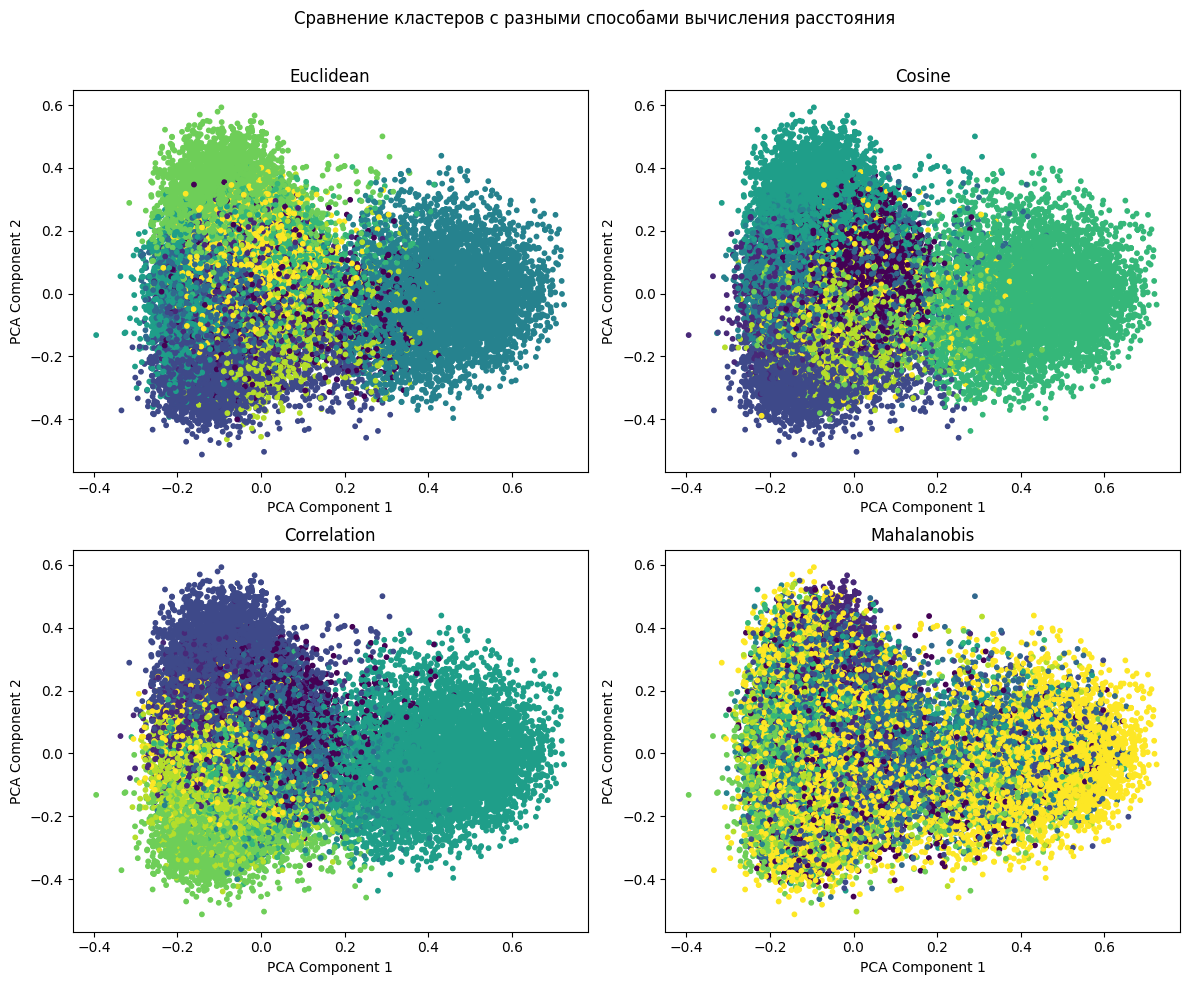

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Сравнение кластеров с разными способами вычисления расстояния")

for idx, metric in enumerate(distance_metrics):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_df[metric], cmap="viridis", s=10)
    ax.set_title(f"{metric.capitalize()}")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Let's print examples of the text for each cluster

In [45]:
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == cluster]
    for text in cluster_texts[:5]:
        print(f"- {text}")


Cluster 0:
- Thanks DB, I'll see if I can find the book
- Awesome! I’m a cradle [RELIGION], so really interesting to hear your experience. Thanks for sharing.
- true I am a troll, but fortunately for me I'm not emotionally invested in it.
- Not the **emotional effect**, when it's in the best interest of our country.
- i wouldn't take that significant of a pay cut. you should keep your job and do your creative writing on the side/free time.

Cluster 1:
- aw, thanks! I appreciate that! 
- Very interesting. Thx
- Oh holy heck :/
- LOL. Super cute!
- Awesome. Thanks!

Cluster 2:
- Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
- His name has already been released. Just can't post it here.
- I miss them being alive
- Super, thanks
- I read on a different post that he died shortly after of internal injuries.

Cluster 3:
- My favourite food is anything I didn't have to cook myself.
- Damn youtube and outrage drama is super luc

## 6. Report

Make a conclusion and write a short report. What are the differnes between the methods used? What are their limitations? What is the applicability of each?

1. Евклидово расстояние
    - **Суть**: Измеряет "прямое" расстояние между двумя точками в пространстве, основываясь на их координатах. Это классический подход к оценке расстояний в пространстве признаков.
    - **Для каких задач подходит**: Хорошо работает на числовых данных, где важно учитывать абсолютные значения признаков, например, для данных, которые расположены на равномерных пространствах.
    - **Минусы**: Чувствителен к масштабу данных, требует нормализации/стандартизации. Также плохо справляется с данными, где важна ориентация векторов, а не их длина.
2. Косинусное расстояние
    - **Суть**: Измеряет угол между векторами, игнорируя их длину. Оно используется для определения, насколько два вектора указывают в одном направлении.
    - **Для каких задач подходит**: Эффективно для текстовых данных или любых векторов, где важна похожесть по направлению, а не абсолютные значения признаков (например, векторные представления слов).
    - **Минусы**: Не учитывает различия в длине векторов, что может быть проблемой для данных, где масштаб имеет значение.
3. Корреляционное расстояние
    - **Суть**: Измеряет, насколько два вектора связаны друг с другом по линейной зависимости, и использует корреляцию для оценки различий.
    - **Для каких задач подходит**: Подходит для задач, где важно выявить связь между признаками, а не их абсолютные значения, например, в экономике, биологии, временных рядах.
    - **Минусы**: Чувствителен к нелинейным зависимостям, не всегда полезен для данных, где зависимость между признаками более сложная.
4. Расстояние Махаланобиса
    - **Суть**: Учитывает корреляцию между признаками и вычисляет расстояние с учетом ковариации. Это метрика, которая адаптируется к распределению данных.
    - **Для каких задач подходит**: Эффективен для многомерных данных, особенно когда признаки взаимосвязаны. Применим для анализа в биометрии, финансах и задачах с сильно скоррелированными признаками.
    - **Минусы**: Требует вычисления и инверсии ковариационной матрицы, что может быть вычислительно затратным для больших данных. Плохо работает с небольшими выборками или сильно коррелированными данными, где ковариационная матрица может быть сингулярной.